In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-22 13:16:44.735708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 13:16:45.328588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-22 13:16:45.938472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 13:16:45.963864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Ceara - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_raw_Ceara_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Ceara - PIB - Per Capita,Ceara - PIB - Preços de Mercado,Ceara - PIB - Estadual,Ceara - PIB - Construção Civil,Ceara - População,Ceara - INCC (%),Ceara - IPCA - Variação mensal durante o Plano Real (%),Ceara - IGP-DI,Ceara - Taxa Selic (%),Ceara - IDH - Longevidade,Ceara - IDH - Renda,Ceara - IDH - Educação,Ceara - NFSP - Fluxo Mensal (Milhões de reais),Ceara - Estoque liquido de capital fixo - (R$),Ceara - Desemprego,Ceara - Produção de Cimento (t),Ceara - Valor,Ceara - Consumo de Cimento (t)
0,2003-01-01,3.964335e+06,2.086772e+06,0.517907,3.420859e+06,7654535.0,1.70,12.53,2.70,0.082293,0.713,0.588,0.377,3.46,6.098524e+06,8.857219,NaN,0.350,81265.0
1,2003-02-01,3.964335e+06,2.086772e+06,0.517907,3.420859e+06,7654535.0,1.51,2.25,2.17,0.088771,0.713,0.588,0.377,3.59,6.172460e+06,8.857219,NaN,0.360,65200.0
2,2003-03-01,3.964335e+06,2.086772e+06,0.517907,3.420859e+06,7654535.0,1.39,3.86,1.59,0.090733,0.713,0.588,0.377,3.84,6.172460e+06,8.857219,NaN,0.360,55165.0
3,2003-04-01,3.964335e+06,2.086772e+06,0.517907,3.420859e+06,7654535.0,1.38,5.13,1.66,0.092749,0.713,0.588,0.377,3.95,6.172460e+06,8.857219,43594.0,0.360,53928.0
4,2003-05-01,3.964335e+06,2.086772e+06,0.517907,3.420859e+06,7654535.0,0.90,6.15,0.41,0.092758,0.713,0.588,0.377,4.06,6.172460e+06,8.857219,101219.0,0.360,65334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,6.771226e+06,1.142538e+07,0.746087,3.927731e+06,9075649.0,0.58,2.42,-0.01,0.024620,0.820,0.680,0.720,0.69,7.827728e+06,12.300000,455729.0,0.378,164440.0
200,2019-09-01,6.771226e+06,1.142538e+07,0.746087,3.927731e+06,9075649.0,0.42,2.54,-0.51,0.022751,0.820,0.680,0.720,0.62,7.827728e+06,12.000000,24230.0,0.378,140298.0
201,2019-10-01,6.771226e+06,1.142538e+07,0.746087,3.927731e+06,9075649.0,0.46,2.49,0.50,0.022035,0.820,0.680,0.720,0.59,7.827728e+06,11.900000,296815.0,0.381,168407.0
202,2019-11-01,6.771226e+06,1.142538e+07,0.746087,3.927731e+06,9075649.0,0.18,2.60,0.55,0.020790,0.820,0.680,0.720,0.57,7.827728e+06,11.700000,109670.0,0.391,163615.0


In [8]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      91.341
1      69.730
2      77.682
3      66.140
4      76.289
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Ceara - Consumo de Cimento (t), Length: 204, dtype: float64

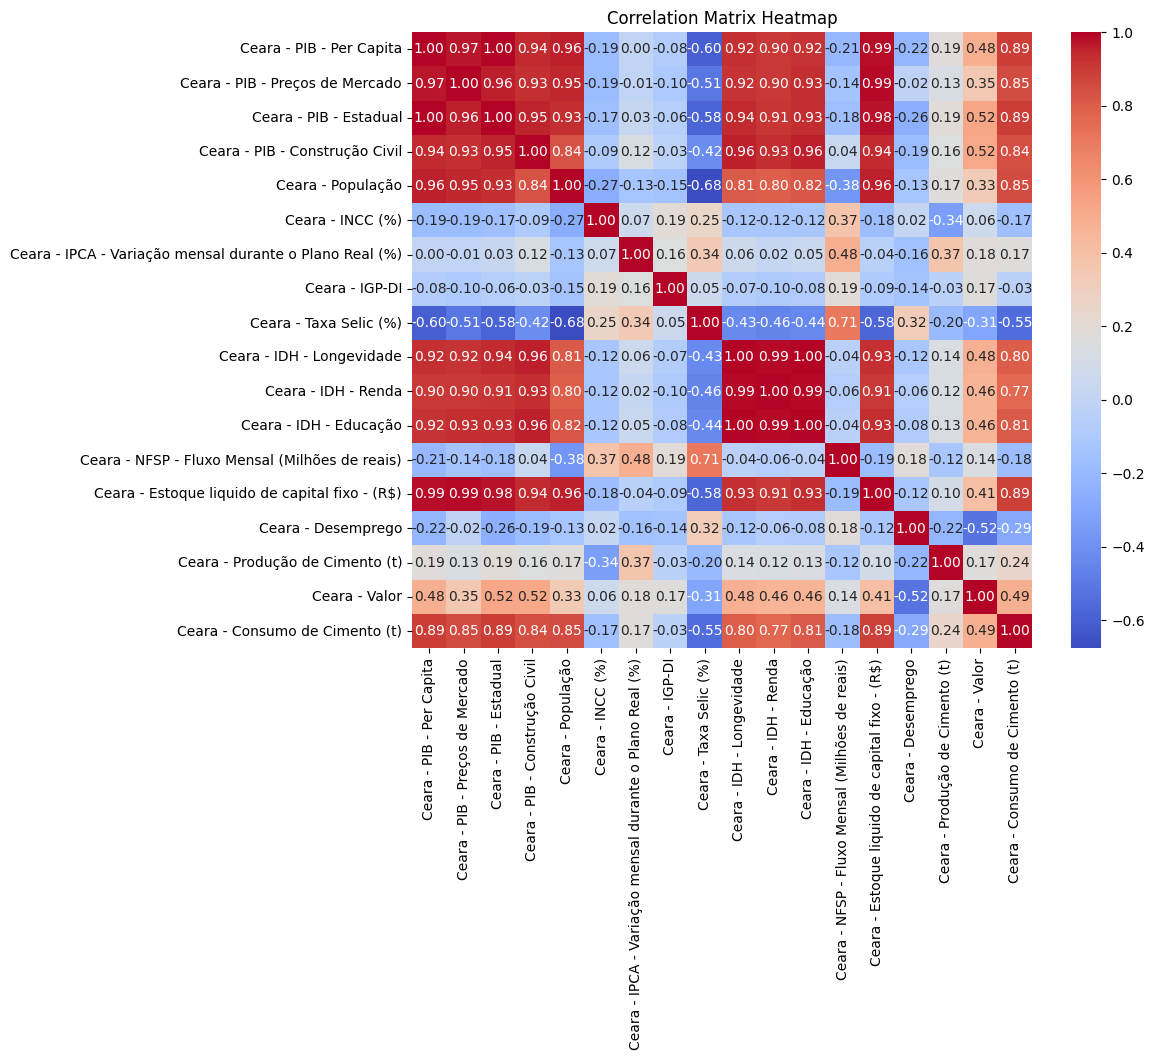

In [9]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [10]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Ceara - PIB - Per Capita,Ceara - PIB - Preços de Mercado,Ceara - PIB - Estadual,Ceara - PIB - Construção Civil,Ceara - População,Ceara - INCC (%),Ceara - IPCA - Variação mensal durante o Plano Real (%),Ceara - IGP-DI,Ceara - Taxa Selic (%),Ceara - IDH - Longevidade,Ceara - IDH - Renda,Ceara - IDH - Educação,Ceara - NFSP - Fluxo Mensal (Milhões de reais),Ceara - Estoque liquido de capital fixo - (R$),Ceara - Desemprego,Ceara - Produção de Cimento (t),Ceara - Valor
0,0.000000,0.0,0.024481,0.254051,0.0,0.611285,1.000000,1.000000,0.840228,0.0,0.0,0.0,0.854722,0.00000,0.450435,-1.000000,0.644330
1,0.000000,0.0,0.024481,0.254051,0.0,0.551724,0.153909,0.865482,0.939126,0.0,0.0,0.0,0.886199,0.04293,0.450435,-1.000000,0.708763
2,0.000000,0.0,0.024481,0.254051,0.0,0.514107,0.286420,0.718274,0.969081,0.0,0.0,0.0,0.946731,0.04293,0.450435,-1.000000,0.708763
3,0.000000,0.0,0.024481,0.254051,0.0,0.510972,0.390947,0.736041,0.999866,0.0,0.0,0.0,0.973366,0.04293,0.450435,0.029206,0.708763
4,0.000000,0.0,0.024481,0.254051,0.0,0.360502,0.474897,0.418782,1.000000,0.0,0.0,0.0,1.000000,0.04293,0.450435,0.099230,0.708763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.869647,1.0,0.799769,0.755015,1.0,0.172414,0.086420,0.238579,0.161726,1.0,1.0,1.0,0.198547,1.00000,0.950679,0.535181,0.322165
176,0.869647,1.0,0.799769,0.755015,1.0,0.191223,0.102058,0.375635,0.114340,1.0,1.0,1.0,0.186441,1.00000,0.950679,0.024370,0.418814
177,0.869647,1.0,0.799769,0.755015,1.0,0.097179,0.115226,0.472081,0.069721,1.0,1.0,1.0,0.174334,1.00000,0.950679,0.158454,0.395619
178,0.869647,1.0,0.799769,0.755015,1.0,0.175549,0.150617,0.340102,0.050532,1.0,1.0,1.0,0.174334,1.00000,0.967119,0.123352,0.403351


In [11]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceara - PIB - Per Capita,Ceara - PIB - Preços de Mercado,Ceara - PIB - Estadual,Ceara - PIB - Construção Civil,Ceara - População,Ceara - INCC (%),Ceara - IPCA - Variação mensal durante o Plano Real (%),Ceara - IGP-DI,Ceara - Taxa Selic (%),Ceara - IDH - Longevidade,Ceara - IDH - Renda,Ceara - IDH - Educação,Ceara - NFSP - Fluxo Mensal (Milhões de reais),Ceara - Estoque liquido de capital fixo - (R$),Ceara - Desemprego,Ceara - Produção de Cimento (t),Ceara - Valor
0,0.000000,0.000000,0.024481,0.254051,0.000000,0.611285,1.000000,1.000000,0.840228,0.0,0.000000,0.00000,0.854722,0.000000,0.450435,-1.000000,0.644330
1,0.000000,0.000000,0.024481,0.254051,0.000000,0.551724,0.153909,0.865482,0.939126,0.0,0.000000,0.00000,0.886199,0.042930,0.450435,-1.000000,0.708763
2,0.000000,0.000000,0.024481,0.254051,0.000000,0.514107,0.286420,0.718274,0.969081,0.0,0.000000,0.00000,0.946731,0.042930,0.450435,-1.000000,0.708763
3,0.000000,0.000000,0.024481,0.254051,0.000000,0.510972,0.390947,0.736041,0.999866,0.0,0.000000,0.00000,0.973366,0.042930,0.450435,0.029206,0.708763
4,0.000000,0.000000,0.024481,0.254051,0.000000,0.360502,0.474897,0.418782,1.000000,0.0,0.000000,0.00000,1.000000,0.042930,0.450435,0.099230,0.708763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.909283,0.926035,0.867236,1.000000,0.954776,0.231975,0.376955,0.215736,0.385830,1.0,0.768293,0.93994,0.418886,0.991571,0.457468,-1.000000,0.322165
164,0.909283,0.926035,0.867236,1.000000,0.954776,0.169279,0.414815,0.423858,0.385830,1.0,0.768293,0.93994,0.406780,0.991571,0.473909,-1.000000,0.386598
165,0.909283,0.926035,0.867236,1.000000,0.954776,0.181818,0.422222,0.322335,0.385830,1.0,0.768293,0.93994,0.409201,0.991571,0.490349,-1.000000,0.378866
166,0.909283,0.926035,0.867236,1.000000,0.954776,0.144201,0.444444,0.347716,0.380510,1.0,0.768293,0.93994,0.384988,0.991571,0.490349,-1.000000,0.385309


In [12]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       91.341
1       69.730
2       77.682
3       66.140
4       76.289
        ...   
163    177.259
164    155.913
165    172.410
166    179.419
167    157.165
Name: Ceara - Consumo de Cimento (t), Length: 168, dtype: float64

In [13]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [14]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [15]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceara - PIB - Per Capita,Ceara - PIB - Preços de Mercado,Ceara - PIB - Estadual,Ceara - PIB - Construção Civil,Ceara - População,Ceara - INCC (%),Ceara - IPCA - Variação mensal durante o Plano Real (%),Ceara - IGP-DI,Ceara - Taxa Selic (%),Ceara - IDH - Longevidade,Ceara - IDH - Renda,Ceara - IDH - Educação,Ceara - NFSP - Fluxo Mensal (Milhões de reais),Ceara - Estoque liquido de capital fixo - (R$),Ceara - Desemprego,Ceara - Produção de Cimento (t),Ceara - Valor
132,0.817137,0.721676,0.792515,0.777340,0.858618,0.109718,0.455144,0.489848,0.155826,0.896907,0.768293,0.87988,0.215496,0.796254,0.194423,1.000000,0.773196
133,0.817137,0.721676,0.792515,0.777340,0.858618,0.354232,0.013992,0.416244,0.170859,0.896907,0.768293,0.87988,0.203390,0.895320,0.276624,-1.000000,0.773196
134,0.817137,0.721676,0.792515,0.777340,0.858618,0.181818,0.070782,0.530457,0.184736,0.896907,0.768293,0.87988,0.198547,0.895320,0.325946,-1.000000,0.773196
135,0.817137,0.721676,0.792515,0.777340,0.858618,0.166144,0.148148,0.690355,0.197075,0.896907,0.768293,0.87988,0.220339,0.895320,0.293065,-1.000000,0.773196
136,0.817137,0.721676,0.792515,0.777340,0.858618,0.354232,0.204115,0.428934,0.209373,0.896907,0.768293,0.87988,0.259080,0.895320,0.260184,-1.000000,0.773196
137,0.817137,0.721676,0.792515,0.777340,0.858618,0.721003,0.242798,0.200508,0.210740,0.896907,0.768293,0.87988,0.273608,0.895320,0.227303,-1.000000,0.837629
138,0.817137,0.721676,0.792515,0.777340,0.858618,0.285266,0.277366,0.154822,0.210740,0.896907,0.768293,0.87988,0.268765,0.895320,0.210863,-1.000000,0.902062
139,0.817137,0.721676,0.792515,0.777340,0.858618,0.313480,0.278189,0.175127,0.210740,0.896907,0.768293,0.87988,0.242131,0.895320,0.177982,-1.000000,0.998711
140,0.817137,0.721676,0.792515,0.777340,0.858618,0.103448,0.299588,0.329949,0.210818,0.896907,0.768293,0.87988,0.234867,0.895320,0.145102,-1.000000,0.966495
141,0.817137,0.721676,0.792515,0.777340,0.858618,0.125392,0.348148,0.319797,0.210740,0.896907,0.768293,0.87988,0.249395,0.895320,0.112221,-1.000000,0.805412


In [16]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [17]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [18]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [19]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [20]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [23]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [24]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[3541816689, 2023350614, 1423318727, 1632126715, 347665294, 1555781704, 1958892208, 1560633219, 2367859212, 1290543858]


Step: 0 ___________________________________________
val_loss: 1147.8426513671875
winner_seed: 3541816689


Step: 1 ___________________________________________
val_loss: 671.7070922851562
winner_seed: 2023350614


Step: 2 ___________________________________________
val_loss: 517.1248168945312
winner_seed: 1423318727


Step: 3 ___________________________________________
val_loss: 494.355712890625
winner_seed: 1632126715


Step: 4 ___________________________________________
val_loss: 556.9182739257812


Step: 5 ___________________________________________
val_loss: 408.6130676269531
winner_seed: 1555781704


Step: 6 ___________________________________________
val_loss: 718.1420288085938


Step: 7 ___________________________________________
val_loss: 660.9080810546875


Step: 8 ___________________________________________
val_loss: 708.3327026367188


Step: 9 ____________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,166.581696,135.704865,133.655228,134.312424,144.574295,164.300827,179.814377,181.875015,181.714661,180.456757,158.920273,177.994736
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,14.980698,6.167862,28.419228,23.477425,16.649292,37.162827,22.686371,17.435013,41.416656,12.049759,4.694733,22.924728


[4001087558, 1068264121, 1364210788, 3596707746, 1359541223, 2258963229, 3182104111, 3293542815, 4036997599, 852368872]


Step: 0 ___________________________________________
val_loss: 797.6536865234375
winner_seed: 4001087558


Step: 1 ___________________________________________
val_loss: 494.0097961425781
winner_seed: 1068264121


Step: 2 ___________________________________________
val_loss: 604.4810791015625


Step: 3 ___________________________________________
val_loss: 745.4619140625


Step: 4 ___________________________________________
val_loss: 585.4054565429688


Step: 5 ___________________________________________
val_loss: 176482.046875


Step: 6 ___________________________________________
val_loss: 499.091796875


Step: 7 ___________________________________________
val_loss: 550.7106323242188


Step: 8 ___________________________________________
val_loss: 811.0823364257812


Step: 9 ___________________________________________
val_loss: 479.967041015625
winner_seed: 852368872
1

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,152.136307,119.809662,119.709381,119.92717,121.303741,124.765335,128.682907,138.086807,139.23761,128.321045,132.668869,122.260818
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,0.535309,9.727341,14.473381,9.092171,6.621262,2.372665,28.445099,26.353195,1.060394,40.085953,30.946136,32.809189


[2249345913, 3384913557, 202302403, 2712132678, 2280279090, 3782539212, 2803105997, 1359081130, 4133285301, 3145401179]


Step: 0 ___________________________________________
val_loss: 559.2340698242188
winner_seed: 2249345913


Step: 1 ___________________________________________
val_loss: 566.4239501953125


Step: 2 ___________________________________________
val_loss: 657.1056518554688


Step: 3 ___________________________________________
val_loss: 279882.0625


Step: 4 ___________________________________________
val_loss: 423.3752136230469
winner_seed: 2280279090


Step: 5 ___________________________________________
val_loss: 516.5806884765625


Step: 6 ___________________________________________
val_loss: 2.8366748879578726e+17


Step: 7 ___________________________________________
val_loss: 461.677001953125


Step: 8 ___________________________________________
val_loss: 403.19586181640625
winner_seed: 4133285301


Step: 9 ___________________________________________
val_loss: 719.751

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,173.704346,174.68663,173.826523,174.646347,198.521042,210.959396,230.594131,243.833862,253.012085,253.355698,251.250626,251.53093
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,22.103348,45.149628,68.590523,63.811348,70.596039,83.821396,73.466125,79.39386,112.714081,84.9487,87.63562,96.460922


[1471202723, 3266084523, 501763377, 4266425074, 3955230137, 2062219479, 3407129808, 4251109289, 3953277910, 3036110282]


Step: 0 ___________________________________________
val_loss: 740.3538208007812
winner_seed: 1471202723


Step: 1 ___________________________________________
val_loss: 654.1697387695312
winner_seed: 3266084523


Step: 2 ___________________________________________
val_loss: 398.626708984375
winner_seed: 501763377


Step: 3 ___________________________________________
val_loss: 665.0585327148438


Step: 4 ___________________________________________
val_loss: 372.3855895996094
winner_seed: 3955230137


Step: 5 ___________________________________________
val_loss: 427.62786865234375


Step: 6 ___________________________________________
val_loss: 760.8882446289062


Step: 7 ___________________________________________
val_loss: 615.6605224609375


Step: 8 ___________________________________________
val_loss: 669.8211669921875


Step: 9 _____________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,187.239777,152.080292,144.977386,143.624847,174.04982,207.527542,218.995483,230.559509,246.115723,246.02536,234.769653,240.835724
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,35.638779,22.543289,39.741386,32.789848,46.124817,80.389542,61.867477,66.119507,105.817719,77.618362,71.154648,85.765717


[1438871772, 3196094015, 220676404, 2125422696, 683217969, 1533645043, 94141193, 979596803, 3712184586, 2113392923]


Step: 0 ___________________________________________
val_loss: 786.0364379882812
winner_seed: 1438871772


Step: 1 ___________________________________________
val_loss: 709.9357299804688
winner_seed: 3196094015


Step: 2 ___________________________________________
val_loss: 663.1526489257812
winner_seed: 220676404


Step: 3 ___________________________________________
val_loss: 684.69091796875


Step: 4 ___________________________________________
val_loss: 1656.888916015625


Step: 5 ___________________________________________
val_loss: 2560732954624.0


Step: 6 ___________________________________________
val_loss: 739.3967895507812


Step: 7 ___________________________________________
val_loss: 732.93896484375


Step: 8 ___________________________________________
val_loss: 494.9109802246094
winner_seed: 3712184586


Step: 9 ___________________________________________
val

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,171.488281,122.973526,125.304657,125.361259,144.30249,159.856567,167.046463,171.561615,180.67691,177.67926,171.35144,169.350037
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,19.887283,6.563477,20.068657,14.52626,16.377487,32.718567,9.918457,7.121613,40.378906,9.272263,7.736435,14.280029


[1194571451, 1038555891, 2316541851, 205554022, 2029296339, 3348179139, 1728668636, 3550043911, 3834539654, 2145696418]


Step: 0 ___________________________________________
val_loss: 764.6104125976562
winner_seed: 1194571451


Step: 1 ___________________________________________
val_loss: 676.6328125
winner_seed: 1038555891


Step: 2 ___________________________________________
val_loss: 2692.01318359375


Step: 3 ___________________________________________
val_loss: 674.1405639648438
winner_seed: 205554022


Step: 4 ___________________________________________
val_loss: 754.7669677734375


Step: 5 ___________________________________________
val_loss: 10051467.0


Step: 6 ___________________________________________
val_loss: 3753.322509765625


Step: 7 ___________________________________________
val_loss: 352.9947814941406
winner_seed: 3550043911


Step: 8 ___________________________________________
val_loss: 30074310.0


Step: 9 ___________________________________________
val_loss: 537.

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,141.732956,117.608887,135.270538,146.178375,154.950241,163.031189,174.217484,165.382736,165.58815,174.899078,170.968552,172.10701
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,9.868042,11.928116,30.034538,35.343376,27.025238,35.893188,17.089478,0.942734,25.290146,6.492081,7.353546,17.037003


[512779498, 3355733108, 1076085600, 1223739469, 2729842844, 667044245, 1319982392, 1716757063, 3742483258, 1721077755]


Step: 0 ___________________________________________
val_loss: 521.0513305664062
winner_seed: 512779498


Step: 1 ___________________________________________
val_loss: 684.3961181640625


Step: 2 ___________________________________________
val_loss: 874.0078125


Step: 3 ___________________________________________
val_loss: 707.279296875


Step: 4 ___________________________________________
val_loss: 476.51971435546875
winner_seed: 2729842844


Step: 5 ___________________________________________
val_loss: 403.925537109375
winner_seed: 667044245


Step: 6 ___________________________________________
val_loss: 833.1341552734375


Step: 7 ___________________________________________
val_loss: 604.8521118164062


Step: 8 ___________________________________________
val_loss: 817.7897338867188


Step: 9 ___________________________________________
val_loss: 882.6311645507812
1

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,164.283981,129.99646,130.159515,130.995255,131.88501,143.99263,150.962875,171.466736,179.486649,178.371567,182.982193,189.72226
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,12.682983,0.459457,24.923515,20.160255,3.960007,16.85463,6.165131,7.026733,39.188644,9.964569,19.367188,34.652252


[2496767707, 2112877060, 2575601213, 2343778802, 3288857551, 3857985810, 2556690287, 282399245, 1542510877, 2261367377]


Step: 0 ___________________________________________
val_loss: 799.6673583984375
winner_seed: 2496767707


Step: 1 ___________________________________________
val_loss: 424.4591369628906
winner_seed: 2112877060


Step: 2 ___________________________________________
val_loss: 522.0689086914062


Step: 3 ___________________________________________
val_loss: 662.0323486328125


Step: 4 ___________________________________________
val_loss: 346.16033935546875
winner_seed: 3288857551


Step: 5 ___________________________________________
val_loss: 561.4078369140625


Step: 6 ___________________________________________
val_loss: 269.79815673828125
winner_seed: 2556690287


Step: 7 ___________________________________________
val_loss: 167180720.0


Step: 8 ___________________________________________
val_loss: 411.3606262207031


Step: 9 ________________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,161.356766,155.649185,155.092316,157.492188,187.013916,192.681,202.69751,204.955444,218.466461,220.633881,194.871826,191.478912
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,9.755768,26.112183,49.856316,46.657188,59.088913,65.542999,45.569504,40.515442,78.168457,52.226883,31.256821,36.408905


[2330412431, 1376523070, 1921482570, 2815856991, 528763876, 150138253, 1110812626, 2564904826, 109971055, 79363060]


Step: 0 ___________________________________________
val_loss: 498.4824523925781
winner_seed: 2330412431


Step: 1 ___________________________________________
val_loss: 569.2636108398438


Step: 2 ___________________________________________
val_loss: 515.0593872070312


Step: 3 ___________________________________________
val_loss: 709.7215576171875


Step: 4 ___________________________________________
val_loss: 669.7288208007812


Step: 5 ___________________________________________
val_loss: 578.5993041992188


Step: 6 ___________________________________________
val_loss: 571.2348022460938


Step: 7 ___________________________________________
val_loss: 343.5991516113281
winner_seed: 2564904826


Step: 8 ___________________________________________
val_loss: 538.91845703125


Step: 9 ___________________________________________
val_loss: 551.2321166992188
1/1 [=============

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,183.893417,153.989456,134.155258,132.647202,158.584854,190.934662,226.216568,227.690781,231.331406,233.458832,226.839462,230.696121
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,32.292419,24.452454,28.919258,21.812202,30.659851,63.796661,69.088562,63.250778,91.033401,65.051834,63.224457,75.626114


[715015570, 937179968, 2723887248, 2872109490, 1710789195, 1637333529, 2253065670, 2377385752, 1273524315, 3301554200]


Step: 0 ___________________________________________
val_loss: 327.7590026855469
winner_seed: 715015570


Step: 1 ___________________________________________
val_loss: 62782926848.0


Step: 2 ___________________________________________
val_loss: 668.2317504882812


Step: 3 ___________________________________________
val_loss: 327.571533203125
winner_seed: 2872109490


Step: 4 ___________________________________________
val_loss: 2708085.25


Step: 5 ___________________________________________
val_loss: 524.3756103515625


Step: 6 ___________________________________________
val_loss: 483.2153625488281


Step: 7 ___________________________________________
val_loss: 424.04107666015625


Step: 8 ___________________________________________
val_loss: 23994576.0


Step: 9 ___________________________________________
val_loss: 628.0958251953125
1/1 [===========================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,191.773621,150.393143,137.734665,134.434372,150.144974,162.278473,167.234314,169.010971,178.236099,170.250275,168.546631,172.027679
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,40.172623,20.85614,32.498665,23.599373,22.219971,35.140472,10.106308,4.570969,37.938095,1.843277,4.931625,16.957672


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,169.419113,141.289215,138.988541,139.961945,156.533051,172.032776,184.64621,190.442337,197.386566,196.345184,189.316956,191.80043
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,17.818113,11.752215,33.752541,29.126945,28.608051,44.894776,27.51821,26.002337,57.088566,27.938184,25.701956,36.73043


In [25]:
display(mae)
display(mape)

172.34688

0.2223793166706717